In [1]:
import sympy as sp
import numpy as np
from moments import *
from maxwellian_equilibrium import *
import matplotlib.pyplot as plt

def plotSympyFunction(f, var, bounds, **kwargs):
    xArr = np.linspace(bounds[0], bounds[1], 101)
    yArr = sp.lambdify(var, f)(xArr)
    plt.plot(xArr, yArr, **kwargs)
    plt.xlabel(var.name)

x, y, z, ζ = sp.symbols("x y z ζ")
frac = sp.Rational

%matplotlib inline
sp.init_printing()

# Construction of improved D3Q19 equilibria

This notebook demonstrates the construction technique of discrete lattice Boltzmann equilibria 
by matching moments of the continuous Maxwellian equilibrium. All steps are implemented in short Python snippets, so that the process can be easily generalized for different stencils or approximation orders if the notebook is run interactively.


The connection between a (lattice) Boltzmann equation to its macroscopic counterpart, the Navier Stokes equations (NSE), can be seen by a Chapman-Enskog expansion. 
The LB equilibrium does not enter the Chapman Enskog analysis directly, only via its moments. 
The idea of our LB equilibrium construction technique is, that if we only approximate the continuous Maxwellian equilibrium, and especially its moments good enough, we are modeling the microscopic system behavior sufficiently accurate, such that in the macroscopic limit the NSE are obtained.


## 1) Moments of continuous Maxwellian equilibrium

Lets first have a look at the continuous Maxwellian equilibrium and how we can compute moments of it using the symbolic algebra toolkit `sympy`. 

We can obtain the Maxwellian equilibrium using a function that is part of the `maxwellian_equilibrium.py` file. It is parametrized with the local density $\rho$, macroscopic velocity $u$ and the speed of sound $c_s$ that is a measure of the temperature.

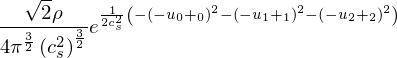

In [2]:
continuousMaxwellianEquilibrium(dim=3)

Lets visualize the 1D version of this distribution:

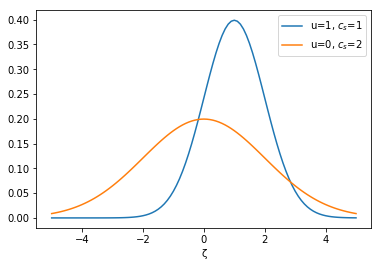

In [3]:
plotSympyFunction(continuousMaxwellianEquilibrium(dim=1, rho=1, u=(1,), ζ=(ζ,), c_s_sq=1),
                  ζ, bounds=(-5, 5),
                  label='u=1, $c_s$=1')
plotSympyFunction(continuousMaxwellianEquilibrium(dim=1, rho=1, u=(0,), ζ=(ζ,), c_s_sq=4),
                  ζ, bounds=(-5, 5),
                  label='u=0, $c_s$=2')
plt.legend();

The continuous equilibrium is a Gaussian bell curve, with mean $u$ and variance related to the speed of sound $c_s$.

The moments of the distribution are integrals over the microscopic velocity $\xi$ over the complete velocity space. `sympy` can evaluate these integrals for us, as can be seen in the next cell with a 1D example.

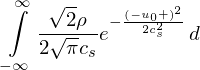

In [4]:
# sympy needs some additional information about c_s to do the integral i.e. that its real and positive
c_s_sq = sp.Symbol("c_s", real=True, positive=True) ** 2   

integral = sp.Integral(continuousMaxwellianEquilibrium(dim=1, ζ=(ζ,), c_s_sq=c_s_sq), 
                       (ζ, -sp.oo, sp.oo))
integral

In [5]:
sp.simplify(integral.doit())

In 1D, continuous moments are defined as: 

$$ \int \xi^n f(\xi) \, dx$$

where $n$ is the order of the moment. Since the distribution function is not normalized to 1 but to $\rho$ the first moment is the expected value times $\rho$:

In [6]:
sp.integrate(ζ * continuousMaxwellianEquilibrium(dim=1, ζ=(ζ,), c_s_sq=c_s_sq), 
             (ζ, -sp.oo, sp.oo)).simplify()

In the following we will use the function `getMomentsOfContinuousMaxwellianEquilibrium` that can do these integrals in a fast and reliable way. We specify moments via polynomials in $x,y,z$ (standing shorthand for $ξ_x, ξ_y, ξ_z$), where $1$ is the zeroth moment, $x$ the first moment (in 1D), $x^2$ the second moment, etc.

In [7]:
# again, compute zeroth and first moment of 1D Maxwellian
getMomentsOfContinuousMaxwellianEquilibrium([1, x, x**2], dim=1)

These concepts generalize naturally to multiple dimensions. In the next cell, for example, we compute moments of the 3D Maxwellian. We can not only specify monomials, but arbitrary polynomials $P(v_x,v_y,v_z)$, so the function computes

$$ \int P(ξ_x, ξ_y, ξ_z) \; f(ξ_x, ξ_y, ξ_z) \, dξ $$

In [8]:
getMomentsOfContinuousMaxwellianEquilibrium([1, x, y, z, x**2 + y**2], dim=3)

Moments of the distribution function have direct physical meaning, the zeroth moment being the local density, the first moments the macroscopic velocity. Higher order moments can be interpreted as fluxes where for example the moment $(\xi_x^2 + \xi_y^2 + \xi_z^2) \xi_x$ is related to the transport of energy along the $x$ axis.


**Truncating higher orders in $u$**

To approximate the NSE, we only have to get the moments right up to a certain order in $u$. Therefor the `getMomentsOfContinuousMaxwellianEquilibrium` can truncate the result at a given order.

The following cell shows this, by first computing the exact moment, then a truncated version.

In [9]:
exact = getMomentsOfContinuousMaxwellianEquilibrium([x**4], dim=3)[0]
truncated = getMomentsOfContinuousMaxwellianEquilibrium([x**4], dim=3, order=3)[0]
exact.expand(), truncated

## 2) Moments of discrete distribution functions

Discrete lattice Boltzmann equilibria can be constructed by projecting the Maxwellian equilibrium onto a Hermite subspace. 

The projection up to second or third order reads

$$
f^{(eq)}_q =  w_i \rho + w_i \rho_0  
                     \left[  3 
                     c_{qα} u_α
                              + \underbrace{  \frac{9}{2} u_α u_β (c_{qα} c_{qβ} - \frac{1}{3} \delta_{αβ})  }_{\mbox{2nd order}}
                              + \underbrace{  \frac{9}{2} \left( u_α u_β u_γ ( c_{qα} c_{qβ} c_{qγ} - \frac{1}{3} c_{qα} \delta_{βγ} )  \right) }_{\mbox{3rd order}}
                     \right]
$$

where $\rho_0=\rho$ yields the standard compressible equilibrium and $\rho_0=1$ an equilibrium that approximates the incompressible NSE. This formula is implemented in the function `discreteMaxwellianEquilibrium`. To get discrete equilibria, additionally a discrete velocity set (stencil) is required. We define the commonly used single speed stencils D2Q9, D3Q19 and D3Q27 in the next cell.

In [10]:
D2Q9 =((0, 0),
       (0, 1), (0, -1), (-1, 0), (1, 0),
       (-1, 1), (1, 1), (-1, -1), (1, -1))
D3Q19 = ((0, 0, 0),
        (0, 1, 0), (0, -1, 0), (-1, 0, 0), (1, 0, 0), (0, 0, 1), (0, 0, -1),
        (-1, 1, 0), (1, 1, 0), (-1, -1, 0), (1, -1, 0),
        (0, 1, 1), (0, -1, 1), (-1, 0, 1), (1, 0, 1),
        (0, 1, -1), (0, -1, -1), (-1, 0, -1), (1, 0, -1))
D3Q27 = ((0, 0, 0),
         (0, 1, 0), (0, -1, 0), (-1, 0, 0), (1, 0, 0), (0, 0, 1), (0, 0, -1),
         (-1, 1, 0), (1, 1, 0), (-1, -1, 0), (1, -1, 0),
         (0, 1, 1), (0, -1, 1), (-1, 0, 1), (1, 0, 1),
         (0, 1, -1), (0, -1, -1), (-1, 0, -1), (1, 0, -1),
         (1, 1, 1), (-1, 1, 1), (1, -1, 1), (-1, -1, 1), (1, 1, -1), (-1, 1, -1), (1, -1, -1), (-1, -1, -1))

The discrete equilibrium is then a vector of equations, one for each direction. The next cell demonstrates this for a compressible D2Q9 equilibrium of second order. The left column shows the stencil direction, the right column the equilibrium term.

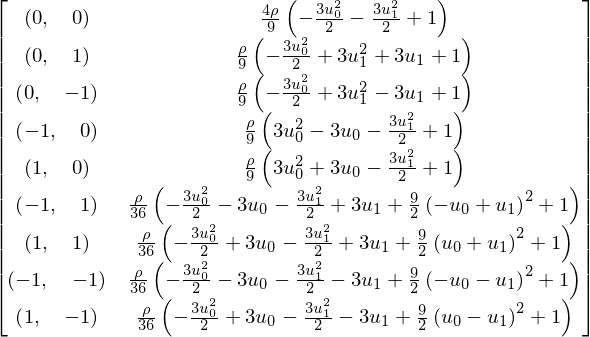

In [11]:
eq = discreteMaxwellianEquilibrium(stencil=D2Q9, compressible=True, order=2)
sp.Matrix([D2Q9, eq]).T

**Computing discrete moments**

Moments of a discrete particle distribution function are computed as weighted sums. This is analogous to the continuous case where integrals are used. For example, to compute the moment $\Pi_{001}$ i.e. $ξ_x^2  ξ_y$ on a continuous distribution function we would evaluate

$$ \int ξ_x^2  ξ_y \; f \; dξ $$

whereas in the discrete case the expression for a stencil $S$ is

$$ \sum_{c_q \in S} c_{qx}^2 c_{qy} \; f_q $$

Implemented in Python this is:

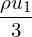

In [12]:
feq = discreteMaxwellianEquilibrium(stencil=D2Q9, compressible=True, order=2)

sum(c_q[0]**2 * c_q[1] * f_q  
    for c_q, f_q in zip(D2Q9, feq)).simplify()

For the discrete case there is also a faster, more convenient function available:

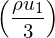

In [13]:
getMomentsOfDiscreteMaxwellianEquilibrium(D2Q9, [x**2 * y], compressible=True, order=2)

**Moment aliasing**

For single speed models, aliasing effects occur when computing discrete moments. 
As an example consider the moment $ξ_0^3 = ξ_0 ξ_0^2$. 

Since $ξ_x \in \{-1, 0, 1\}$ for single speed models, the factor $ξ_0^2=1$ for all possible values. That means we get the same result for moments with odd exponent $ξ_0, ξ_0^3, ξ_0^5, ...$.

Similarly the moments $ξ_0^2, ξ_0^4, ξ_0^6, ...$ have the same value.

In [14]:
getMomentsOfDiscreteMaxwellianEquilibrium(D2Q9, [x**1, x**3, x**5, x**7], order=2)

Consequently there are maximally $d^3$ moments in $d$ dimensions that have different values. These are the moments $\xi_{0}^{e_0} \cdot \xi_{1}^{e_1} \cdots \xi_{d}^{e_d}$ with exponents $e_i \in \{0, 1, 2\}$.

In two dimensions these are the  moments

In [15]:
allIndependentMomentsD2Q9 = exponentsToPolynomialRepresentations(momentsUpToComponentOrder(2, dim=2))
allIndependentMomentsD2Q9

All higher order monomial moments share their value with one of these lower order moments. The are "aliased" and not independent.

## 3) Comparing moments of continuous and discrete equilibrium

Lets first consider the case of stencils with "full" neighborhood, namely D2Q9 and D3Q27.
A discrete distribution function on these stencils has 9 or 27 values. There are also 9 or 27
independent moments that can take on different values. 

Now lets compare the moments of the discrete and the continuous equilibrium.
Since the discrete equilibrium was derived as a projection of the continuous Maxwellian equilibrium we expect that at least all moments up to order 2 are equal. 

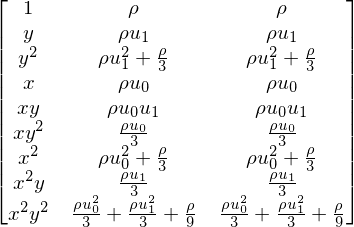

In [16]:
indepMoments2D = exponentsToPolynomialRepresentations(momentsUpToComponentOrder(2, dim=2))

discreteEqMomentsD2Q9 = getMomentsOfDiscreteMaxwellianEquilibrium(D2Q9, indepMoments2D, compressible=True, order=2)
contEqMoments2D = getMomentsOfContinuousMaxwellianEquilibrium(indepMoments2D, dim=2, order=2, c_s_sq=frac(1,3))

sp.Matrix([indepMoments2D, discreteEqMomentsD2Q9, contEqMoments2D]).T

The first column shows the moment, the second column the discrete equilibrium moment and the last column the continuous equilibrium moment. Not only the moments up to second order agree (as was guaranteed by the Hermite construction), but also higher order moments like the forth order moment $x^2 y^2$. 

A Chapman Enskog analysis shows that the NSE are approximated regardless of forth (or higher) order equilibrium moment values. Only the error terms are affected. 

The same check is done for three dimensions with the D3Q27 stencil in the next cell. 

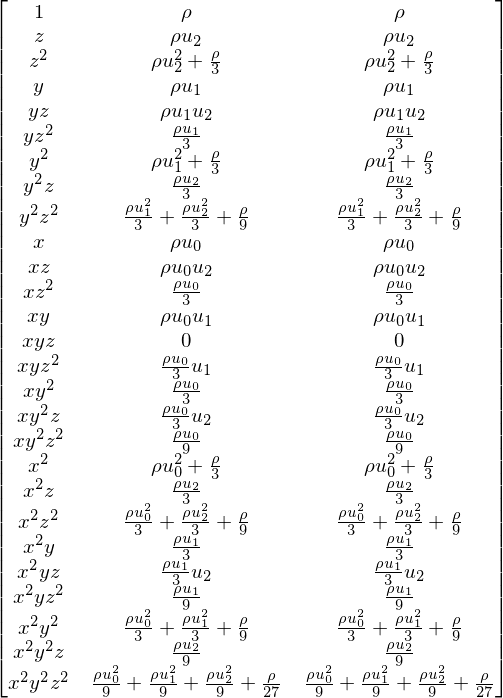

In [17]:
indepMoments3D = exponentsToPolynomialRepresentations(momentsUpToComponentOrder(2, dim=3))

discreteEqMomentsD3Q27 = getMomentsOfDiscreteMaxwellianEquilibrium(D3Q27, indepMoments3D, compressible=True, order=2)
contEqMoments3D = getMomentsOfContinuousMaxwellianEquilibrium(indepMoments3D, dim=3, order=2, c_s_sq=frac(1,3))

sp.Matrix([indepMoments3D, discreteEqMomentsD3Q27, contEqMoments3D]).T

Again all discrete moments have the same values as their continuous counterparts.

Note that we have truncated the continuous moments at order 2 in $u$ to get this perfect agreement. 
Similarly we would get perfect agreement if we use the 3rd order discrete equilibrium and truncate the continuous moments at order 3. 

To switch off truncation, choose `order=None` when calling `getMomentsOfContinuousMaxwellianEquilibrium`.


**Constructing equilibra from moments**

The fact that discrete and continuous equilibrium moments agree, can be used to construct discrete equilibria. For the velocity sets D2Q9 and D3Q27 there are 9 or 27 degrees of freedom and the same number of independent moments. The moment matrix $M$ that transforms between the spatial representation and the moment representation is invertible. Thus if we pick 9 or 27 equilibrium moments we can construct a unique equilibrium. 

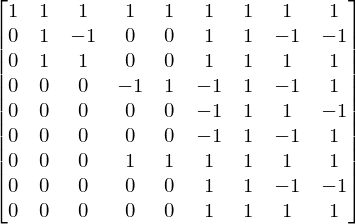

In [18]:
M_D2Q9 = momentMatrix(moments=indepMoments2D, stencil=D2Q9)
assert M_D2Q9.det() != 0, "Determinant of moment matrix is zero - not invertible"
M_D2Q9

Now the discrete equilibrium can be derived as $M^{-1} m_{eq}$ where $m_{eq}$ are moment of the continuous Maxwellian.

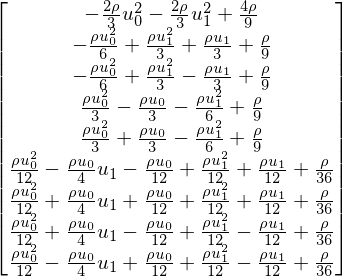

In [19]:
m_eq = getMomentsOfContinuousMaxwellianEquilibrium(indepMoments2D, dim=2, order=2, c_s_sq=frac(1,3))

newlyConstructedEq = M_D2Q9.inv() * sp.Matrix(m_eq)

# Compare newly constructed equilibrium to standard discrete equilibrium from literature - has to be the same
discreteEq = discreteMaxwellianEquilibrium(stencil=D2Q9, compressible=True, order=2)
assert sp.simplify(newlyConstructedEq - sp.Matrix(discreteEq)) == sp.Matrix([0]*9)

newlyConstructedEq

As expected, we obtain the same standard discrete equilibrium, which is usually derived using a Hermite projection approach. For the D2Q9 and D3Q27 stencils our moment matching approach leads to the same results.
In contrast to the Hermite approach, our moment matching technique can be implemented in *sympy* in a very straightforward way. 

## 4) Improved D3Q19 equilibrium

While for D2Q9 and D3Q27 our construction technique yields the same results as the standard equilibrium known from literature, a different result is obtained for the D3Q19 stencil.

First, one has to select 19 independent moments out of the possible 27. We use the same moment set used for D3Q19 MRT methods, that leaves out the following moments

In [20]:
exponentsToLeaveOut = [(1, 2, 2), (1, 1, 2), (2, 2, 2), (1, 1, 1)]
exponentsToLeaveOut = extendMomentsWithPermutations(exponentsToLeaveOut)
nonMatchedMoments = exponentsToPolynomialRepresentations(exponentsToLeaveOut)
nonMatchedMoments

However, other moment selections are possible as well, as long as all second and third order moments, that are required to approximate the NSE, are not altered.

In [21]:
d3q19moments = tuple(set(indepMoments3D) - set(nonMatchedMoments))
assert len(d3q19moments) == 19
d3q19moments

To get our new equilibrium, we repeat the process outlined above for D2Q9, compute the moment values of the continuous equilibrium for these 19 moments, and transform them back with $M^{-1}$

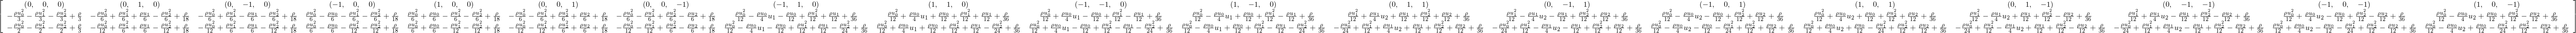

In [22]:
d3q19_eq_moments = getMomentsOfContinuousMaxwellianEquilibrium(d3q19moments, dim=3, order=2, c_s_sq=frac(1,3))
M_D3Q19 = momentMatrix(moments=d3q19moments, stencil=D3Q19)
improvedD3Q19 = M_D3Q19.inv() * sp.Matrix(d3q19_eq_moments)

standardD3Q19 = sp.Matrix(discreteMaxwellianEquilibrium(D3Q19, order=2)).expand()

sp.Matrix([D3Q19, improvedD3Q19.T, standardD3Q19.T])

In above matrix, the difference between both equilibrium formulations can be seen in detail. The first row contains the stencil entry, the second our improved equilibrium while the last row is the standard second order equilibrium. The equilibrium moment values have been truncated at velocity order $2$ to be comparable. 

The difference between both formulations is not due to velocity truncation order. The next cell compares both construction techniques again, this time for velocity truncation order of 3.

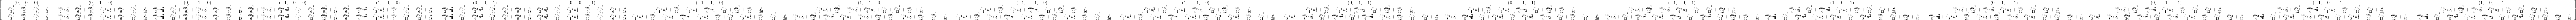

In [23]:
d3q19_eq_moments = getMomentsOfContinuousMaxwellianEquilibrium(d3q19moments, dim=3, order=3, c_s_sq=frac(1,3))
M_D3Q19 = momentMatrix(moments=d3q19moments, stencil=D3Q19)
improvedD3Q19 = M_D3Q19.inv() * sp.Matrix(d3q19_eq_moments)

standardD3Q19 = sp.Matrix(discreteMaxwellianEquilibrium(D3Q19, order=3)).expand()

sp.Matrix([D3Q19, improvedD3Q19.T, standardD3Q19.T])

For isothermal hydrodynamic simulations the second order truncated equilibrium is usually sufficient and is computationally less expensive.

Finally we compare the moments of both equilibra. Since our new equilibrium has the same moments as the Maxwellian, we effectively compare the differences of the standard equilibrium moments to Maxwellian moments.

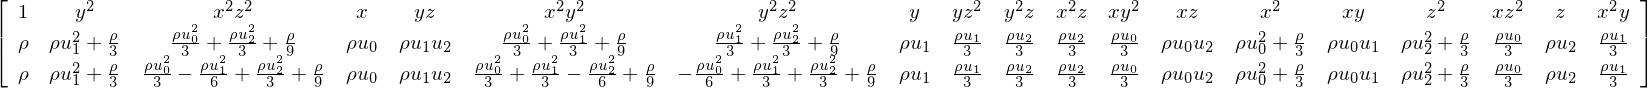

In [24]:
comparisonOrder=2

sp.Matrix([d3q19moments,  
           getMomentsOfContinuousMaxwellianEquilibrium(d3q19moments, dim=3, c_s_sq=frac(1,3), order=comparisonOrder),
           getMomentsOfDiscreteMaxwellianEquilibrium(D3Q19, d3q19moments, order=comparisonOrder)]).expand()

When comparing only up to velocity truncation order 2, the only difference are the forth order moments.
At velocity truncation order 3, as is shown in the next cell, also the values of third order moments are different.

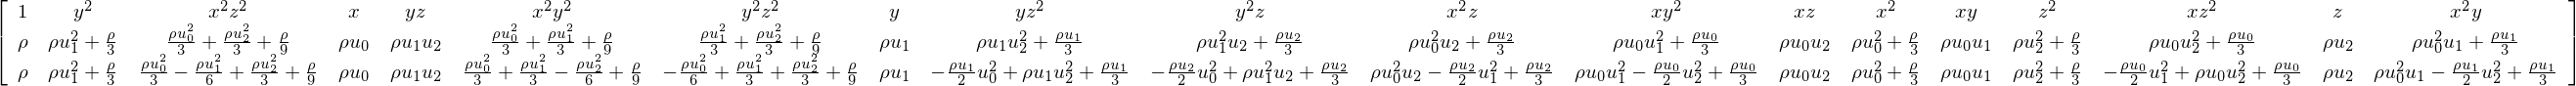

In [25]:
comparisonOrder=3

sp.Matrix([d3q19moments,  
           getMomentsOfContinuousMaxwellianEquilibrium(d3q19moments, dim=3, c_s_sq=frac(1,3), order=comparisonOrder),
           getMomentsOfDiscreteMaxwellianEquilibrium(D3Q19, d3q19moments, order=comparisonOrder)]).expand()

**Incompressible Version**

The incompressible version of the equilibrium can be obtained by setting $\rho=1$ in the Maxwellian moment values. This substitution is only done in terms that contain also factors of the macroscopic velocity components $u_i$. 

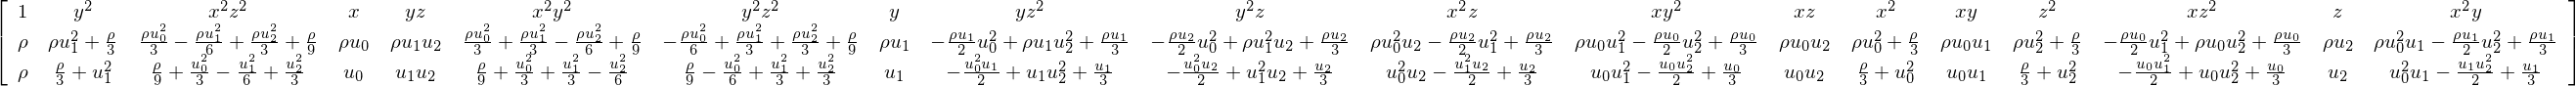

In [26]:
compressibleMoments = getMomentsOfDiscreteMaxwellianEquilibrium(D3Q19, d3q19moments, order=comparisonOrder)
incompressibleMoments = [compressibleToIncompressibleMomentValue(m, sp.Symbol("rho"), sp.symbols("u_:3")) 
                         for m in compressibleMoments]
sp.Matrix([d3q19moments, compressibleMoments, incompressibleMoments])

The second order moment $x^2$, for example, has the value $\frac{\rho}{3} + \rho u_0^2$ and is replaced by the incompressible version $\frac{\rho}{3} +  u_0^2$.
The first term is not modified since it is not multiplied by any velocity component, while in the second part the density is set to $1$. 

The validity of this modification can be shown via a Chapman Enskog analysis, which is done in the next section.